In [1]:
import torch

if not torch.cuda.is_available():
    raise ValueError("Change notebook runtime to GPU !")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
current_dir = '/content/drive/My Drive/三年前期水2　機械学習/後半'

In [4]:
import sys

sys.path.append(current_dir)
%cd $current_dir

/content/drive/My Drive/三年前期水2　機械学習/後半


In [5]:
import os
dataset_dir = os.path.join(current_dir, 'opcdata')

In [6]:
import har_dl_utils

{100.0: 0, 200.0: 1, 300.0: 2, 400.0: 3, 500.0: 4, 600.0: 5, 700.0: 6, 800.0: 7, 900.0: 8, 1000.0: 9, 8100.0: 10}
{0: 100.0, 1: 200.0, 2: 300.0, 3: 400.0, 4: 500.0, 5: 600.0, 6: 700.0, 7: 800.0, 8: 900.0, 9: 1000.0, 10: 8100.0}


In [32]:
import numpy as np
from scipy.signal import butter, filtfilt
import os

# バンドパスフィルタの定義
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

# npzファイルを読み込む関数
def load_npz_file(file_path):
    data = np.load(file_path)
    return data['ts_list'], data['label_list'], data['time_list'], data['key_list']

# フィルタリングされたデータを保存する関数
def save_filtered_data(file_path, filtered_data, labels, times, keys):
    np.savez(file_path, ts_list=filtered_data, label_list=labels, time_list=times, key_list=keys)

# フィルタリング処理
def process_and_save_npz_row_by_row(input_file_path, output_file_path, lowcut, highcut, fs, order=5):
    data, labels, times, keys = load_npz_file(input_file_path)

    filtered_data = []

    for row in data:
        filtered_row = bandpass_filter(row, lowcut, highcut, fs, order)
        filtered_data.append(filtered_row)

    filtered_data = np.array(filtered_data)

    save_filtered_data(output_file_path, filtered_data, labels, times, keys)

# パラメータ設定
dataset_dir = '/content/drive/My Drive/三年前期水2　機械学習/後半/opcdata'
input_files = ['train.npz', 'val.npz', 'test.npz', 'submission.npz']
output_files = ['train_filtered.npz', 'val_filtered.npz', 'test_filtered.npz', 'submission_filtered.npz']

lowcut = 1  # Hz
highcut = 9  # Hz
fs = 20  # サンプリング周波数（Hz）
order = 5

# 各ファイルに対してフィルタリング処理を実行
for input_file, output_file in zip(input_files, output_files):
    input_file_path = os.path.join(dataset_dir, input_file)
    output_file_path = os.path.join(dataset_dir, output_file)
    process_and_save_npz_row_by_row(input_file_path, output_file_path, lowcut, highcut, fs, order)

print("フィルタリング処理が完了しました。")


フィルタリング処理が完了しました。


In [33]:
train_dataset = har_dl_utils.OpcDataset(os.path.join(dataset_dir, 'train_filtered.npz'))
val_dataset = har_dl_utils.OpcDataset(os.path.join(dataset_dir, 'val_filtered.npz'))
test_dataset = har_dl_utils.OpcDataset(os.path.join(dataset_dir, 'test_filtered.npz'))
submission_dataset = har_dl_utils.OpcDataset(os.path.join(dataset_dir, 'submission_filtered.npz'))

In [34]:
import torch
train_loader= torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        drop_last=True,
        shuffle=True
    )

val_loader= torch.utils.data.DataLoader(
        val_dataset,
        batch_size=32,
        drop_last=False,
        shuffle=False
    )

test_loader= torch.utils.data.DataLoader(
        test_dataset,
        batch_size=32,
        drop_last=False,
        shuffle=False
    )

submission_loader= torch.utils.data.DataLoader(
        submission_dataset,
        batch_size=32,
        drop_last=False,
        shuffle=False
    )

In [35]:
import torch.nn as nn
import torch.optim as optim

input_dim = 12
hidden_dim = 32
lstm_num_layers = 1  # LSTM層の数
output_dim = 11
dropout_rate = 0.3
learning_rate = 0.001
epochs = 1000

モデルの設計

In [36]:
class ImprovedLSTMClassifier(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, lstm_num_layers, output_dim, dropout_rate):
        super(ImprovedLSTMClassifier, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(32, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, lstm_hidden_dim, lstm_num_layers, batch_first=True, bidirectional=True)
        self.fc1 =nn.Linear(hidden_dim*2, hidden_dim)
        self.fc2 =nn.Linear(hidden_dim, hidden_dim)
        self.fc3 =nn.Linear(hidden_dim, hidden_dim)
        self.fc4 =nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        h_n = self.conv1(x)
        h_n = self.dropout(h_n)
        h_n = self.conv2(h_n)
        h_n = self.relu(h_n)
        h_n = self.dropout(h_n)
        h_n = self.conv3(h_n)
        h_n = self.dropout(h_n)
        h_n = self.conv4(h_n)
        h_n = self.relu(h_n)
        h_n = self.dropout(h_n)

        h_n = h_n.permute(0, 2, 1)

        h_0 = torch.zeros(2 * lstm_num_layers, h_n.size(0), hidden_dim).to(device)
        c_0 = torch.zeros(2 * lstm_num_layers, h_n.size(0), hidden_dim).to(device)

        h_n, _ = self.lstm(h_n, (h_0, c_0))
        h_n = self.fc1(h_n[:, -1, :])
        x = self.fc2(h_n)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [37]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = ImprovedLSTMClassifier(input_dim, hidden_dim, lstm_num_layers, output_dim, dropout_rate)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# GPU使用が過多になりすぎないように途中で終わらす
max_batches = 100
# max_batches = len(train_loader)

for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []
    for batch_idx, (inputs, targets, times, keys) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.to(torch.int64)) #形状と型を同じにする
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if batch_idx >= max_batches:
            break

    if epoch % 50 == 0:
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets, times, keys in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.to(torch.int64))
                val_losses.append(loss.item())

        print(f'Epoch {epoch}: Train Loss: {sum(train_losses)/len(train_losses):.4f}, '
              f'Validation Loss: {sum(val_losses)/len(val_losses):.4f}')

Epoch 50: Train Loss: 1.6238, Validation Loss: 1.5270
Epoch 100: Train Loss: 1.5083, Validation Loss: 1.3396
Epoch 150: Train Loss: 1.4197, Validation Loss: 1.3270
Epoch 200: Train Loss: 1.3648, Validation Loss: 1.2211
Epoch 250: Train Loss: 1.2998, Validation Loss: 1.1422
Epoch 300: Train Loss: 1.2644, Validation Loss: 1.1349
Epoch 350: Train Loss: 1.2359, Validation Loss: 1.1272
Epoch 400: Train Loss: 1.2342, Validation Loss: 1.0975
Epoch 450: Train Loss: 1.2336, Validation Loss: 1.1036
Epoch 500: Train Loss: 1.2101, Validation Loss: 1.0265
Epoch 550: Train Loss: 1.1486, Validation Loss: 1.0363
Epoch 600: Train Loss: 1.1701, Validation Loss: 1.0761
Epoch 650: Train Loss: 1.1509, Validation Loss: 1.0102
Epoch 700: Train Loss: 1.1120, Validation Loss: 1.0787
Epoch 750: Train Loss: 1.1010, Validation Loss: 1.0160
Epoch 800: Train Loss: 1.0819, Validation Loss: 1.0149
Epoch 850: Train Loss: 1.1142, Validation Loss: 1.0199
Epoch 900: Train Loss: 1.0952, Validation Loss: 1.0118
Epoch 950: 

モデル保存

In [39]:
torch.save(model.state_dict(), './model.pth')

評価

In [40]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets, times, keys in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.numpy())

    cm = confusion_matrix(all_targets, all_predictions)
    class_f1_scores = f1_score(all_targets, all_predictions, average=None) # クラスごとのF1スコアを計算

    return class_f1_scores, cm, all_predictions

# クラス名を定義
class_names = [har_dl_utils.activities[key] for key in har_dl_utils.activities.keys()]

# モデル評価
class_f1_scores, cm, all_predictions = evaluate_model(model, test_loader)

for activity, f1_score in zip(class_names, class_f1_scores):
    print(f"{activity}: {f1_score:.4f}")

Picking: 0.7004
Relocate Item Label: 0.7179
Assemble Box: 0.5525
Insert Items: 0.6787
Close Box: 0.4907
Attach Box Label: 0.5522
Scan Label: 0.8229
Attach Shipping Label: 0.7610
Put on Back Table: 0.4725
Fill out Order: 0.8545
Null: 0.0000


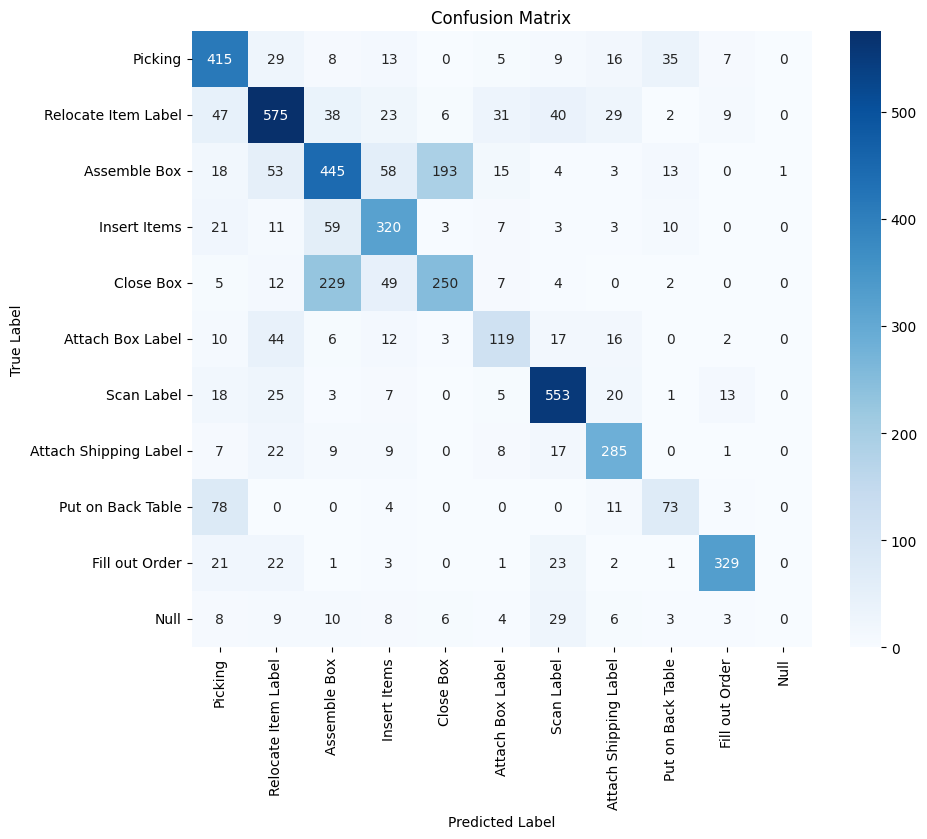

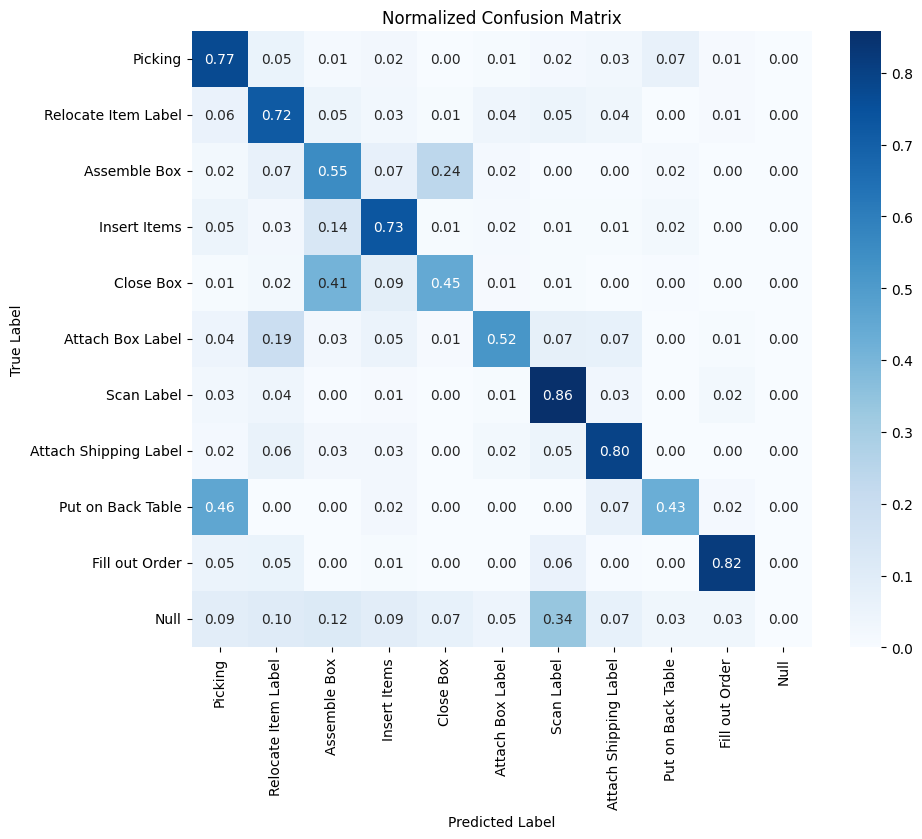

In [41]:
import har_dl_viz

# インスタンス数で表示
har_dl_viz.plot_confusion_matrix(cm, class_names, normalize=False)

# 比率で表示
har_dl_viz.plot_confusion_matrix(cm, class_names, normalize=True)

In [42]:
# 正解ラベルとの比較
har_dl_viz.compare_predictions(all_predictions, test_dataset)

Dropdown(description='Select Key:', options=('U0102-S0300', 'U0106-S0300', 'U0202-S0300', 'U0210-S0300'), valu…

Button(description='Plot', style=ButtonStyle())

提出用データ作成

In [43]:
har_dl_utils.make_submission(model, submission_loader, device)

{'U0104-S0100': {'unixtime': [1637032675000, 1637032676000, 1637032677000, 1637032678000, 1637032679000, 1637032680000, 1637032681000, 1637032682000, 1637032683000, 1637032684000, 1637032685000, 1637032686000, 1637032687000, 1637032688000, 1637032689000, 1637032690000, 1637032691000, 1637032692000, 1637032693000, 1637032694000, 1637032695000, 1637032696000, 1637032697000, 1637032698000, 1637032699000, 1637032700000, 1637032701000, 1637032702000, 1637032703000, 1637032704000, 1637032705000, 1637032706000, 1637032707000, 1637032708000, 1637032709000, 1637032710000, 1637032711000, 1637032712000, 1637032713000, 1637032714000, 1637032715000, 1637032716000, 1637032717000, 1637032718000, 1637032719000, 1637032720000, 1637032721000, 1637032722000, 1637032723000, 1637032724000, 1637032725000, 1637032726000, 1637032727000, 1637032728000, 1637032729000, 1637032730000, 1637032731000, 1637032732000, 1637032733000, 1637032734000, 1637032735000, 1637032736000, 1637032737000, 1637032738000, 1637032739